# 随机森林

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/logo.png" width=150>

在本节课，我们将探索决策树，并且拓展它到随机森林。这种类型的模型，和我们之前见过的线性和逻辑回归不同，他们没有权重但是有很好的可解释性。




# 概述

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/dtree.jpg" width=350>

* **目标:**  给出一些数据，选择特征并且决定以什么样的方式分裂数据来做出预测。
* **优点:**
  * 决策树可以做成分类树和回归树。
  * 具有很强的可解释性.
  * 仅需很少的数据预处理。
* **缺点:**
  * 当训练数据少于分类类别的时候表现很差。
* **其他:** 一组决策树可以构成随机森林，预测结果也会由所有的决策树所决定。

# 训练

我们来看上方的决策树样例，它用来决策外面的天气是否可以在外玩耍。数据有三个特征(weather, humiditiy和wind) 和结果 (yes or no).

*步骤*: 
1.   基于每一个特征进行分割(例如. 根据三个特征来判断结果是yes还是no）
2.   计算每个特征分裂时候的损失。一些热门的算法比如使用Gini系数来计算的CART算法，还有使用熵和信息增益来计算的ID3。它们都基本上测量了预测值中的杂质或者无序。详细请见 [blog post](https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1) 一个详尽的信息增益计算步骤。

  * $ H(X) = \sum_{c \in C} -p(c) log_2p(c)$
  * where:
      * H(X): 数据集X的熵
      * C: 类别集合
      * p(c): 在c类别中和所有实例的占比
      
  对于一个二分类任务来说，如果所有的样例在一个类别下都是相同的，那么它的熵值为0，如果仅有一半是正确的，那么它的熵值则为1（也是最差的情况等同于瞎猜）。一旦我们决定了熵值，我们需要计算出信息增益(IG)(比如. 在我们把数据X基于特征F分裂后不确定的样本减少了多少)。
  
  * $ IG(F, X) = H(S) - \sum_{t\in T}p(t)H(t) $
  * where:
      * IG(F. X): 数据X基于特征F分裂后的信息增益
      * H(X): 数据集X的熵
      * T: 基于分裂F后的子集
      * p(t): 所有实例中t的实例数的比例
      * H(t): 子集t的熵
      
 **注意**: 对于回归问题，你可以用标准偏差（standard deviation）来取代信息增益。

3.   在所有的特征分裂后，信息增益最高的分裂将作为第一个特征的分裂(也就是决策树的根).
4.   基于第一次分裂后，重复上述的步骤在余下的所有特征中。最后，我们将分裂到叶子结点，在叶子结点中大部分样本将会来自同一类。

  

# 数据

我们来加载在第三节课中用到的titanic数据集

In [53]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [54]:
# 参数
args = Namespace(
    seed=1234,
    data_file="titanic.csv",
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
    max_depth=4,
    min_samples_leaf=5,
    n_estimators=10, # 随机森林中包含的决策树个数
)

# 设置随即种子来保证实验结果的可重复性。
np.random.seed(args.seed)

In [55]:
# 从GitHub上加载数据到notebook本地驱动
url = "https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/data/titanic.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as f:
    f.write(html)

In [56]:
# 把CSV文件内容读到DataFrame中
df = pd.read_csv(args.data_file, header=0)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0


# Scikit-learn实现

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [58]:
# 预处理
def preprocess(df):
  
    # 删除掉含有空值的行
    df = df.dropna()

    # 删除基于文本的特征 (我们以后的课程将会学习怎么使用它们)
    features_to_drop = ["name", "cabin", "ticket"]
    df = df.drop(features_to_drop, axis=1)

    # pclass, sex, 和 embarked 是类别变量
    # 我们将把字符串转化成浮点数，不再是逻辑回归中的编码变量
    df['sex'] = df['sex'].map( {'female': 0, 'male': 1} ).astype(int)
    df["embarked"] = df['embarked'].dropna().map( {'S':0, 'C':1, 'Q':2} ).astype(int)

    return df

In [59]:
# 数据预处理
df = preprocess(df)
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,1,0,29.0000,0,0,211.3375,0,1
1,1,1,0.9167,1,2,151.5500,0,1
2,1,0,2.0000,1,2,151.5500,0,0
3,1,1,30.0000,1,2,151.5500,0,0
4,1,0,25.0000,1,2,151.5500,0,0


In [60]:
# 划分数据到训练集和测试集
mask = np.random.rand(len(df)) < args.train_size
train_df = df[mask]
test_df = df[~mask]
print ("Train size: {0}, test size: {1}".format(len(train_df), len(test_df)))

Train size: 199, test size: 71


In [61]:
# 分离 X 和 y
X_train = train_df.drop(["survived"], axis=1)
y_train = train_df["survived"]
X_test = test_df.drop(["survived"], axis=1)
y_test = test_df["survived"]

**注意**: 你可以随意改动 max_depth 和 min_samples 来观察决策树表现好坏的变化。
我们怎么知道什么时候可以停止分裂？如果我们有一个很多特征的数据集，我们的决策树也会非常大。如果我们一直去分裂，我们终究会导致过拟合。所以这里有一些处理办法可以参考：

*  设置在叶子节点中的最少样本个数。
*  设置一个最大的深度(也就是从树根到叶子节点的最大距离)。
*  通过删除几乎没有信息增益的特征对决策树进行剪枝。

In [62]:
# 初始化模型
dtree = DecisionTreeClassifier(criterion="entropy", random_state=args.seed, 
                               max_depth=args.max_depth, 
                               min_samples_leaf=args.min_samples_leaf)

In [63]:
# 训练
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

In [64]:
# 预测
pred_train = dtree.predict(X_train)
pred_test = dtree.predict(X_test)

# 评估

In [65]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [66]:
# 正确率
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.82, test acc: 0.70


In [67]:
# 计算其他的模型评估指标
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

precision: 0.70. recall: 0.79, F1: 0.75


# 可解释性

In [68]:
# 安装必要的包
!apt-get install graphviz
!pip install pydotplus

/bin/sh: apt-get: command not found


In [69]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

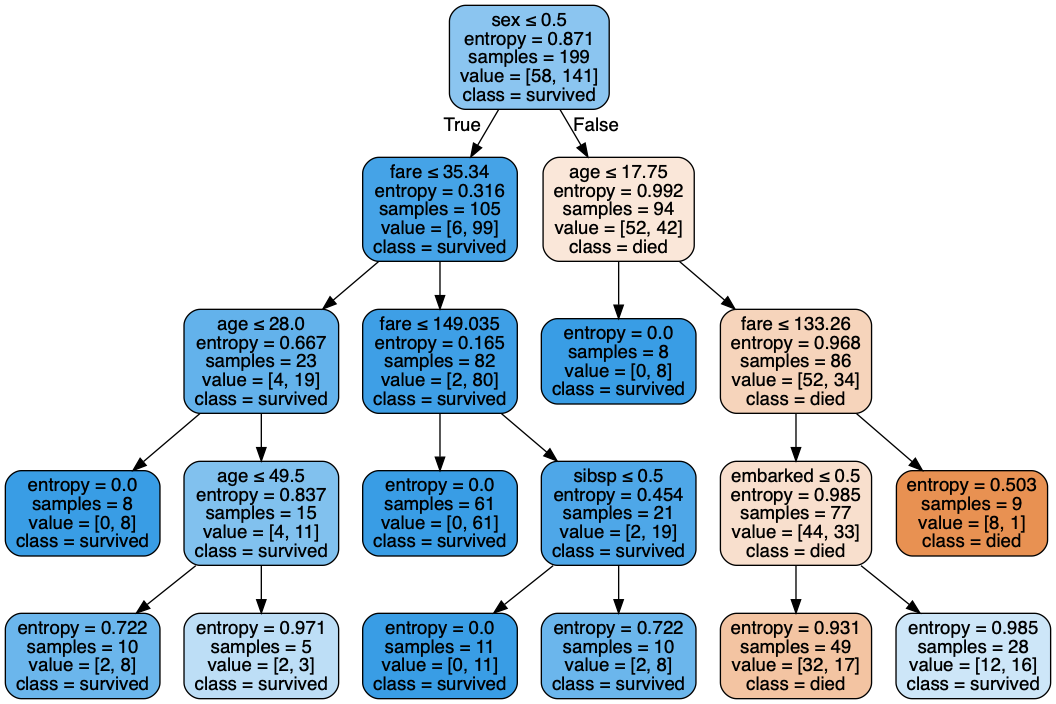

In [70]:
# 可解释性
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, 
                feature_names=list(train_df.drop(['survived'], axis=1)), 
                class_names = ['died', 'survived'],
                rounded = True, filled= True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png(), width=500, height=300)

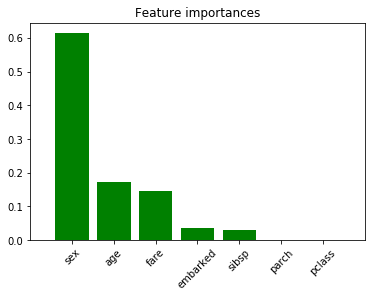

sex - 0.615
age - 0.174
fare - 0.147
embarked - 0.035
sibsp - 0.030
parch - 0.000
pclass - 0.000


In [71]:
# 特征重要性
features = list(X_test.columns)
importances = dtree.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# 画出树中的特征重要性
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# 打印值
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

# 随机森林

随机森林由一组，或者说一个集成的决策树在一起构建。它的意图是，与单个决策树相比，一组不同的树将产生更准确的预测。 但是如果我们在相同的数据下用相同的分裂条件比如说信息增益，那么怎么保证每棵树又是不同的呢？这里的解决方法是随机森林中的不同决策树由不同的数据子集组成，甚至不同的特征阈值。

<img src="https://raw.githubusercontent.com/LisonEvf/practicalAI-cn/master/images/forest.png" width=600>

# Scikit-learn 实现

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
# 初始化随机森林
forest = RandomForestClassifier(
    n_estimators=args.n_estimators, criterion="entropy", 
    max_depth=args.max_depth, min_samples_leaf=args.min_samples_leaf)

In [74]:
# 训练
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
# 预测
pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

In [76]:
# 正确率
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

# 计算其他评估指标 
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

train acc: 0.80, test acc: 0.68
precision: 0.65. recall: 0.87, F1: 0.75


# 可解释性

检查随机森林正确性并获得特征重要性非常容易。

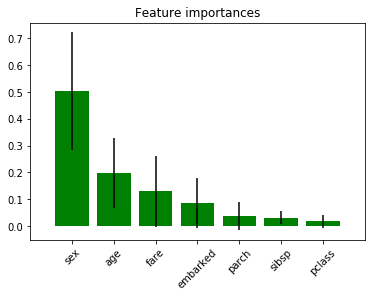

sex - 0.503
age - 0.198
fare - 0.129
embarked - 0.086
parch - 0.037
sibsp - 0.031
pclass - 0.017


In [77]:
# 特征重要性
features = list(X_test.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# 画出树中的特征重要性
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], yerr=std[indices], 
        color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# 打印
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

# 网格搜索

在我们的随机森林中，我们有许多不同的超参数(criterion, max_depth, 等等)甚至在以后的课程中我们会见到很多的模型有更多的超参数。我们怎么知道应该选择什么样的值？我们必须根据它们在验证集上产生的性能来调整它们。Scikit learn提供了详尽的网格搜索功能，以便我们可以调整我们的超参数。

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
# 创建网格的参数 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50],
    'max_features': [len(features)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 8],
    'n_estimators': [5, 10, 50] # of trees
}

In [80]:
# 初始化随机森林
forest = RandomForestClassifier()

In [81]:
# 实例化网格搜索
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=1)

In [82]:
# 网格搜索拟合数据
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    0.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [10, 20, 50], 'max_features': [7], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [4, 8], 'n_estimators': [5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [83]:
# 查看最佳参数组合
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 10}

In [84]:
# 使用最佳参数训练
best_forest = grid_search.best_estimator_
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
# 预测
pred_train = best_forest.predict(X_train)
pred_test = best_forest.predict(X_test)

In [86]:
# 正确率
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

# 计算其他评价指标
precision, recall, F1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary")
print ("precision: {0:.2f}. recall: {1:.2f}, F1: {2:.2f}".format(precision, recall, F1))

train acc: 0.90, test acc: 0.70
precision: 0.70. recall: 0.79, F1: 0.75


# TODO

- regression example
- gini vs. entropy